# Conductance-based generalized leaky integrate and fire (GLIF) neuron example

### Configure the plot design

In [1]:
import nest
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: May  5 2022 07:35:57

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

plt.style.use(["science"])
plt.rcParams["figure.figsize"] = (8, 8)

# mpl.rcParams["font.serif"] = ["Times New Roman"]

In [3]:
nest.ResetKernel()
resolution = 0.05
nest.resolution = resolution


Apr 01 11:08:42 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.05 ms.


### Creating the neurons

In [4]:
n_lif = nest.Create(
    "glif_cond",
    params={
        "spike_dependent_threshold": False,
        "after_spike_currents": False,
        "adapting_threshold": False,
    },
)
n_lif_r = nest.Create(
    "glif_cond",
    params={
        "spike_dependent_threshold": True,
        "after_spike_currents": False,
        "adapting_threshold": False,
    },
)
n_lif_asc = nest.Create(
    "glif_cond",
    params={
        "spike_dependent_threshold": False,
        "after_spike_currents": True,
        "adapting_threshold": False,
    },
)
n_lif_r_asc = nest.Create(
    "glif_cond",
    params={
        "spike_dependent_threshold": True,
        "after_spike_currents": True,
        "adapting_threshold": False,
    },
)
n_lif_r_asc_a = nest.Create(
    "glif_cond",
    params={
        "spike_dependent_threshold": True,
        "after_spike_currents": True,
        "adapting_threshold": True,
    },
)

neurons = n_lif + n_lif_r + n_lif_asc + n_lif_r_asc + n_lif_r_asc_a

### Creating the stimualtion

In [5]:
espikes = nest.Create(
    "spike_generator",
    params={"spike_times": [10.0, 100.0, 150.0], "spike_weights": [20.0] * 3},
)
ispikes = nest.Create(
    "spike_generator",
    params={"spike_times": [15.0, 99.0, 150.0], "spike_weights": [-20.0] * 3},
)
cg = nest.Create(
    "step_current_generator",
    params={
        "amplitude_values": [
            400.0,
        ],
        "amplitude_times": [
            200.0,
        ],
        "start": 200.0,
        "stop": 500.0,
    },
)
pg = nest.Create(
    "poisson_generator", params={"rate": 15000.0, "start": 600.0, "stop": 900.0}
)
pn = nest.Create("parrot_neuron")

### Connecting the network

In [6]:
nest.Connect(cg, neurons, syn_spec={"delay": resolution})
nest.Connect(espikes, neurons, syn_spec={"delay": resolution, "receptor_type": 1})
nest.Connect(ispikes, neurons, syn_spec={"delay": resolution, "receptor_type": 2})
nest.Connect(pg, pn, syn_spec={"delay": resolution})
nest.Connect(pn, neurons, syn_spec={"delay": resolution, "receptor_type": 1})

### Connect a multimeter

In [7]:
mm = nest.Create(
    "multimeter",
    params={
        "interval": resolution,
        "record_from": [
            "V_m",
            "I",
            "g_1",
            "g_2",
            "threshold",
            "threshold_spike",
            "threshold_voltage",
            "ASCurrents_sum",
        ],
    },
)
nest.Connect(mm, neurons)

In [8]:
sr = nest.Create("spike_recorder")
nest.Connect(neurons, sr)

### Simulate

In [9]:
nest.Simulate(1000.0)

data = mm.events
senders = data["senders"]

spike_data = sr.events
spike_senders = spike_data["senders"]
spikes = spike_data["times"]


Apr 01 11:08:43 NodeManager::prepare_nodes [Info]: 
    Preparing 12 nodes for simulation.

Apr 01 11:08:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Apr 01 11:08:43 SimulationManager::run [Info]: 
    Simulation finished.


### Plot the result

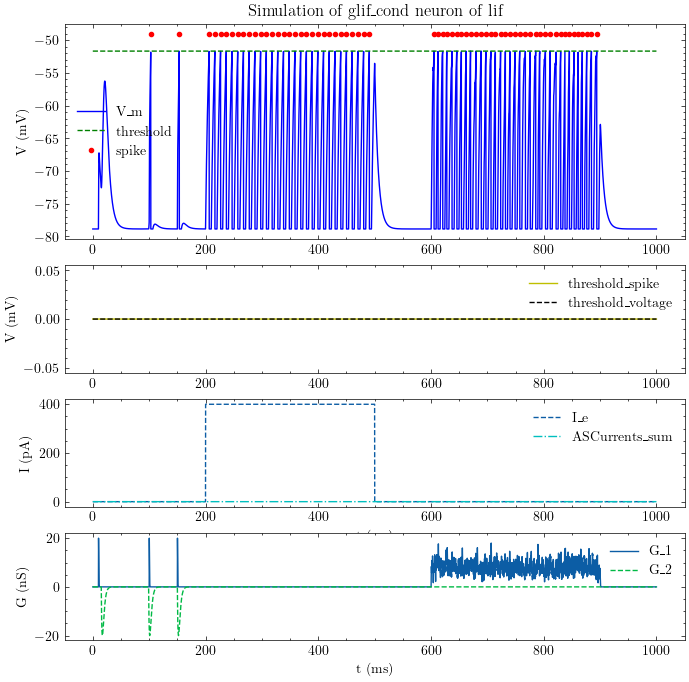

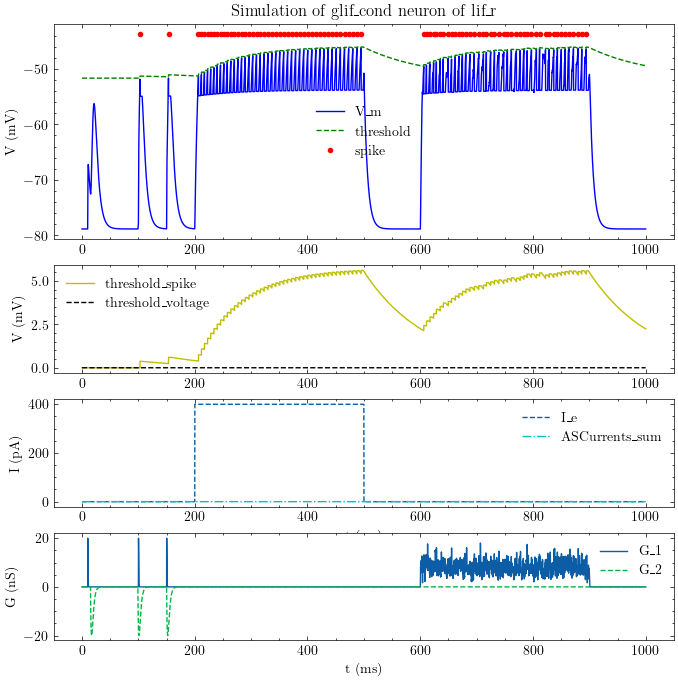

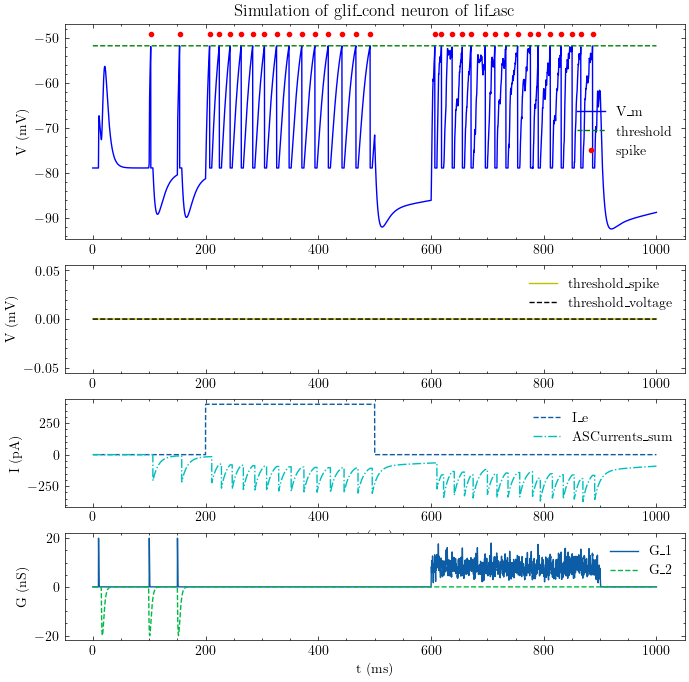

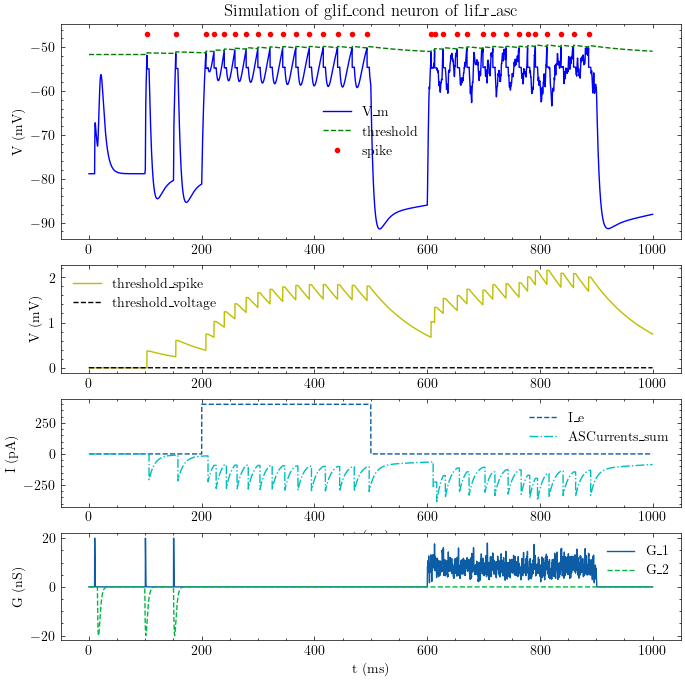

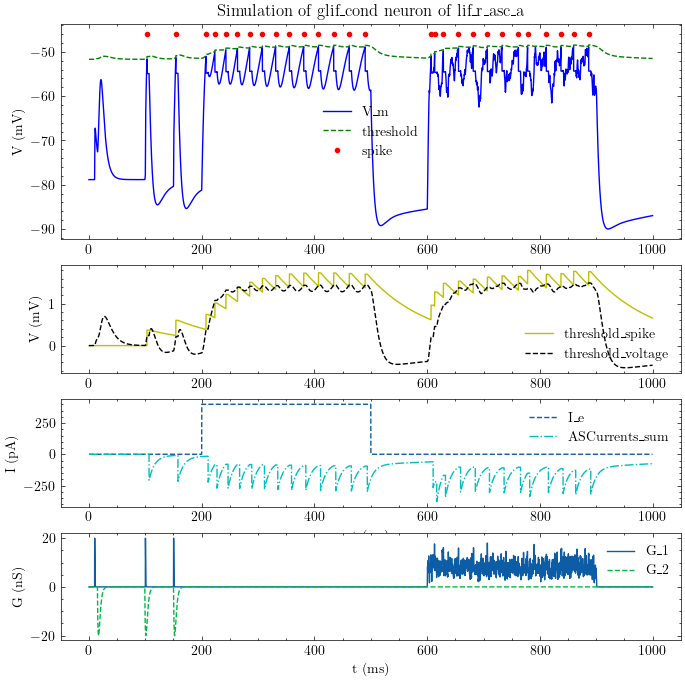

In [10]:
glif_models = ["lif", "lif_r", "lif_asc", "lif_r_asc", "lif_r_asc_a"]
for i in range(len(glif_models)):

    glif_model = glif_models[i]
    node_id = neurons[i].global_id
    plt.figure(glif_model)
    gs = gridspec.GridSpec(4, 1, height_ratios=[2, 1, 1, 1])
    t = data["times"][senders == 1]

    ax1 = plt.subplot(gs[0])
    plt.plot(t, data["V_m"][senders == node_id], "b")
    plt.plot(t, data["threshold"][senders == node_id], "g--")
    plt.plot(
        spikes[spike_senders == node_id],
        [max(data["threshold"][senders == node_id]) * 0.95]
        * len(spikes[spike_senders == node_id]),
        "r.",
    )
    plt.legend(["V_m", "threshold", "spike"])
    plt.ylabel("V (mV)")
    plt.title("Simulation of glif_cond neuron of " + glif_model)

    ax2 = plt.subplot(gs[1])
    plt.plot(t, data["threshold_spike"][senders == node_id], "y")
    plt.plot(t, data["threshold_voltage"][senders == node_id], "k--")
    plt.legend(["threshold_spike", "threshold_voltage"])
    plt.ylabel("V (mV)")

    ax3 = plt.subplot(gs[2])
    plt.plot(t, data["I"][senders == node_id], "--")
    plt.plot(t, data["ASCurrents_sum"][senders == node_id], "c-.")
    plt.legend(["I_e", "ASCurrents_sum", "I_syn"])
    plt.ylabel("I (pA)")
    plt.xlabel("t (ms)")

    ax4 = plt.subplot(gs[3])
    plt.plot(t, data["g_1"][senders == node_id], "-")
    plt.plot(t, data["g_2"][senders == node_id], "--")
    plt.legend(["G_1", "G_2"])
    plt.ylabel("G (nS)")
    plt.xlabel("t (ms)")

plt.show()